In [1]:
import cryo
import polars as pl
import binascii
import web3
import json
from eth_abi import decode
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

In [2]:
# The multical cantract address, but we also need ABI
MULTICALL3_ADDRESS = '0xcA11bde05977b3631167028862bE2a173976CA11'
MULTICALL3_ABI=json.loads('[{"inputs":[{"internalType":"bool","name":"requireSuccess","type":"bool"},{"components":[{"internalType":"address","name":"target","type":"address"},{"internalType":"bytes","name":"callData","type":"bytes"}],"internalType":"struct Multicall3.Call[]","name":"calls","type":"tuple[]"}],"name":"tryAggregate","outputs":[{"components":[{"internalType":"bool","name":"success","type":"bool"},{"internalType":"bytes","name":"returnData","type":"bytes"}],"internalType":"struct Multicall3.Result[]","name":"returnData","type":"tuple[]"}],"stateMutability":"payable","type":"function"}]')

UNIV2_ETH_USDC= '0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc'
UNIV3_WBTC_ETH = '0xCBCdF9626bC03E24f779434178A73a0B4bad62eD'

In [3]:
# Functions
def bytes_to_hexstr(b: any) -> str:
    if isinstance(b,list):
        return [bytes_to_hexstr(a) for a in b]
    return '0x' + b.hex()

def decode_outputdata_uniV2_price(b: bytes) -> list[float]:
    aggregated_data_uniV2 = decode(['(bool,bytes)[]'], b)[0]

    ethusdc_reserves_raw = aggregated_data_uniV2[0]
    [eth_bal, usdc_bal, _] = decode(['uint112','uint112','uint32'], ethusdc_reserves_raw[1])

    eth_usdc_price = (eth_bal / usdc_bal)*1e12
    print(f"ETH/USDC: {eth_usdc_price}")


def decode_outputdata_uniV2V3_price(b: bytes) -> list[float]:
    aggregated_data_uniV2V3 = decode(['(bool,bytes)[]'], b)[0]

    # UNI-V2
    ethusdc_reserves_raw = aggregated_data_uniV2V3[0]
    [eth_bal, usdc_bal, time ] = decode(['uint112','uint112','uint32'], ethusdc_reserves_raw[1])

    eth_usdc_price = (eth_bal / usdc_bal)*1e12
    print(f"ETH/USDC: {eth_usdc_price}")

    # UNI-V3
    # slot0():
    # sqrtPriceX96 uint160, tick int24, observationIndex uint16, observationCardinality uint16, observationCardinalityNext uint16, feeProtocol uint8, unlocked bool
    # 'uint160', 'int24', 'uint16', 'uint16', 'uint16', 'uint8', 'bool'

    wbtc_eth_slot0_raw = aggregated_data_uniV2V3[1]
    wbtc_eth_slot0_sqrt_ratioX96 = decode(['uint160', 'int24', 'uint16', 'uint16', 'uint16', 'uint8', 'bool'], wbtc_eth_slot0_raw[1])[0]
    wbtc_eth_price = wbtc_eth_slot0_sqrt_ratioX96**2 / 2**192 /1e10
    eth_wbtc_price = 1/wbtc_eth_price
    print(f"WBTC/ETH: { wbtc_eth_price}")
    print(f"ETH/WBTC: { eth_wbtc_price}")

    # Timestamp
    timestamp_raw = aggregated_data_uniV2V3[-1]
    timestamp = int(timestamp_raw[1].hex(),16)
    
    return [eth_usdc_price, eth_wbtc_price,timestamp]

In [4]:
# Function Signatures 4 bytes
getBlocknumber_4b = '42cbb15c'
getBloclTimestamp_4b= '0f28c97d'
getReserves_4b = '0902f1ac'
slot0_4b = '3850c7bd'

In [5]:
txs = cryo.collect('transactions', blocks=['-10:21881984'], rpc ='https://eth.merkle.io')

In [6]:
bytes_to_hexstr(txs['transaction_hash'].to_list())[:10]

['0x17185afe19659c8a5f93a2a547058db9c660805f625400dcc89c015f0b405088',
 '0x5fbf92a74814561ad37de87b5e2c1fd590211af35c7d87e5785790dbceab1830',
 '0x72abd91c2ac8a5cf8706d663c2629acb28db1771f8363469b516a8eb509393f8',
 '0x93c047dc4368b039206159771a5165f3223c6b85d1e951c058fa3000338098cd',
 '0x1ac8af088ae8f77d094366408676245819caf9bcbba06a490887596764b1261b',
 '0xd46fe78a7aa9113b89ca90444b32b243a71cc3dfb809afa8c7016e9904782e8b',
 '0x0fca8e8943eefbad34ffea7f28a18f27b2897ec6a75cd068fc523b68c00618bf',
 '0x74ad3f7a7fc8caff74fabc5933cbd9ecd32d97a0f039ab0c488f7990a184f294',
 '0xf82048f49848fd81d37187adb7de887f2e0cb85f3d2c04a85455c38cb98ffd90',
 '0x6050315ae98f0eb328c6fae15c2759b4335d9fbc7883e463c410d3e710eeca01']

In [7]:
# web3 instance, function from web3py
w3 = web3.Web3()
m3 = w3.eth.contract(address = MULTICALL3_ADDRESS, abi=MULTICALL3_ABI)

### Get Block Number

In [8]:
aggregate_calldata = [
    [
        MULTICALL3_ADDRESS,
        f'0x{getBlocknumber_4b}',
    ]
]
calldata = m3.encode_abi("tryAggregate", args=[True, aggregate_calldata])

In [9]:
# Args of the tryAggregate function
aggregate_calldata

[['0xcA11bde05977b3631167028862bE2a173976CA11', '0x42cbb15c']]

### Some Explanation:
##### calldata: this is the call data with info we want to get
##### 0xbce38bd7 = tryAggregate(bool,(address,bytes)[])
##### aggregate_calldata = are the function arguments 
##### address = Multicall_address, 
##### bytes = Function Sign getblocknumber_4b = '42cbb15c'
##### if you see the output of call data info all there

In [10]:
# This is the encoded data to use as calldata
# 0xbce38bd7 = tryAggregate(bool,(address,bytes)[])
# Multiclall Address + Block function signature
calldata

'0xbce38bd70000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000020000000000000000000000000ca11bde05977b3631167028862be2a173976ca110000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000000442cbb15c00000000000000000000000000000000000000000000000000000000'

In [11]:
cryo_kwargs = {
    'rpc': 'https://eth.merkle.io',
    'blocks': ['latest'], 
}
            
eth_call_df = cryo.collect(
    'eth_calls',
    to_address = [MULTICALL3_ADDRESS],
    call_data=[calldata],
     output_format="polars",
    **cryo_kwargs,
)

In [12]:
eth_call_df['output_data'][0]

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00 \x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00 \x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00 \x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01N\x9fl'

In [13]:
outdata = eth_call_df['output_data'][0]

In [14]:
print(outdata.hex())

00000000000000000000000000000000000000000000000000000000000000200000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000002000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000002000000000000000000000000000000000000000000000000000000000014e9f6c


In [15]:
decoded_data =decode(['(bool,bytes)[]'], outdata)[0]

In [16]:
decoded_data[0]

(True,
 b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01N\x9fl')

In [17]:
# this is boolean and list first is true (we set in arg above)
decoded_data[0][1]

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01N\x9fl'

In [18]:
# Call data last 7 bytes is the block number in hex
#  we call it from block function
int(decoded_data[0][1].hex(),16)

21929836

## From UNI-V2: USDC >> ETH/USDC price

In [19]:
# web3 instance, function from web3py: done above
aggregate_calldata_uniV2 = [
    [
        UNIV2_ETH_USDC,
        f'0x{getReserves_4b}',
    ]
]
calldata_uniV2 = m3.encode_abi("tryAggregate", args=[False, aggregate_calldata_uniV2])

In [20]:
print(calldata_uniV2)

0xbce38bd70000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000020000000000000000000000000b4e16d0168e52d35cacd2c6185b44281ec28c9dc000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000040902f1ac00000000000000000000000000000000000000000000000000000000


In [21]:
cryo_kwargs = {
    'rpc': 'https://eth.merkle.io',
    'blocks': ['latest'], 
}
            
eth_call_uniV2_df = cryo.collect(
    'eth_calls',
    to_address = [MULTICALL3_ADDRESS],
    call_data=[calldata_uniV2],
     output_format="polars",
    **cryo_kwargs,
)

#### From UNI-V2: USDC >> Reserves

In [22]:
outdata_uniV2= eth_call_uniV2_df['output_data'][0]

In [23]:
#  0x will give in order 1-Hex USDC Reserve 2-Hex ETH Reserve 3-Timestamp
outdata_uniV2.hex()

'00000000000000000000000000000000000000000000000000000000000000200000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000002000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000006000000000000000000000000000000000000000000000000000000aa6772584f80000000000000000000000000000000000000000000000ff80fb15455ae2dfac0000000000000000000000000000000000000000000000000000000067bee94f'

In [24]:
decoded_data_uniV2 = decode(['(bool,bytes)[]'], outdata_uniV2)[0]

In [25]:
decoded_data_uniV2 

((True,
  b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\n\xa6w%\x84\xf8\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\x80\xfb\x15EZ\xe2\xdf\xac\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00g\xbe\xe9O'),)

In [26]:
reserves_data_uniV2 = decode(['uint112','uint112','uint32'], decoded_data_uniV2[0][1])

In [27]:
reserves_data_uniV2

(11710079796472, 4713213784439566557100, 1740564815)

#### From UNI-V2: USDC >> ETH/USDC price Def

In [28]:
output_data_uniV2= eth_call_uniV2_df['output_data'][0]

In [29]:
decode_outputdata_uniV2_price(output_data_uniV2)

ETH/USDC: 2484.5212485655175


#### From UNI-V3: WBTC >> WBTC/ETH price Def

##### In this case we add the function we want to call to the previous one, so we call:
- UNIV2_ETH_USDC
- UNIV3_WBTC_ETH

In [30]:
# web3 instance, function from web3py: Done
# Aggreagte call data for V2 and V3

aggregate_calldata_uniV2_V3 = [
    [
        UNIV2_ETH_USDC,
        f'0x{getReserves_4b}',
    ],
    [
        UNIV3_WBTC_ETH,
        f'0x{slot0_4b}',
    ],
    [
        MULTICALL3_ADDRESS,
        f'0x{getBloclTimestamp_4b}'
    ]

]
calldata_uniV2_V3 = m3.encode_abi("tryAggregate", args=[False, aggregate_calldata_uniV2_V3])

In [31]:
aggregate_calldata_uniV2_V3

[['0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc', '0x0902f1ac'],
 ['0xCBCdF9626bC03E24f779434178A73a0B4bad62eD', '0x3850c7bd'],
 ['0xcA11bde05977b3631167028862bE2a173976CA11', '0x0f28c97d']]

In [32]:
print(calldata_uniV2_V3)

0xbce38bd7000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000400000000000000000000000000000000000000000000000000000000000000003000000000000000000000000000000000000000000000000000000000000006000000000000000000000000000000000000000000000000000000000000000e00000000000000000000000000000000000000000000000000000000000000160000000000000000000000000b4e16d0168e52d35cacd2c6185b44281ec28c9dc000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000040902f1ac00000000000000000000000000000000000000000000000000000000000000000000000000000000cbcdf9626bc03e24f779434178a73a0b4bad62ed000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000043850c7bd00000000000000000000000000000000000000000000000000000000000000000000000000000000ca11bde05977b3631167028862be2a173976ca11000000000000000000000000000000

In [33]:
cryo_kwargs = {
    'rpc': 'https://eth.merkle.io',
    'blocks': ['-500:latest'], 
}

eth_call_uniV2_V3_df = cryo.collect(
    'eth_calls',
    to_address = [MULTICALL3_ADDRESS],
    call_data=[calldata_uniV2_V3],
     output_format="polars",
    **cryo_kwargs,
)

In [34]:
eth_call_uniV2_V3_df

block_number,contract_address,call_data,output_data,chain_id
u32,binary,binary,binary,u64
21929339,"b""\xca\x11\xbd\xe0Yw\xb3c\x11g\x02\x88b\xbe*\x179v\xca\x11""","b""\xbc\xe3\x8b\xd7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00""…","b""\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x20\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00""…",1
21929340,"b""\xca\x11\xbd\xe0Yw\xb3c\x11g\x02\x88b\xbe*\x179v\xca\x11""","b""\xbc\xe3\x8b\xd7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00""…","b""\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x20\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00""…",1
21929341,"b""\xca\x11\xbd\xe0Yw\xb3c\x11g\x02\x88b\xbe*\x179v\xca\x11""","b""\xbc\xe3\x8b\xd7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00""…","b""\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x20\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00""…",1
21929342,"b""\xca\x11\xbd\xe0Yw\xb3c\x11g\x02\x88b\xbe*\x179v\xca\x11""","b""\xbc\xe3\x8b\xd7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00""…","b""\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x20\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00""…",1
21929343,"b""\xca\x11\xbd\xe0Yw\xb3c\x11g\x02\x88b\xbe*\x179v\xca\x11""","b""\xbc\xe3\x8b\xd7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00""…","b""\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x20\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00""…",1
…,…,…,…,…
21929834,"b""\xca\x11\xbd\xe0Yw\xb3c\x11g\x02\x88b\xbe*\x179v\xca\x11""","b""\xbc\xe3\x8b\xd7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00""…","b""\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x20\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00""…",1
21929835,"b""\xca\x11\xbd\xe0Yw\xb3c\x11g\x02\x88b\xbe*\x179v\xca\x11""","b""\xbc\xe3\x8b\xd7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00""…","b""\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x20\x00\x00

In [35]:
outdata_uniV2V3 = eth_call_uniV2_V3_df['output_data'][0]

In [36]:
# output_data_V2V3.hex()
outdata_uniV2V3.hex()

'0000000000000000000000000000000000000000000000000000000000000020000000000000000000000000000000000000000000000000000000000000000300000000000000000000000000000000000000000000000000000000000000600000000000000000000000000000000000000000000000000000000000000120000000000000000000000000000000000000000000000000000000000000026000000000000000000000000000000000000000000000000000000000000000010000000000000000000000000000000000000000000000000000000000000040000000000000000000000000000000000000000000000000000000000000006000000000000000000000000000000000000000000000000000000a9973fbbe66000000000000000000000000000000000000000000000100b9a1f5e9c935545a0000000000000000000000000000000000000000000000000000000067bed1670000000000000000000000000000000000000000000000000000000000000001000000000000000000000000000000000000000000000000000000000000004000000000000000000000000000000000000000000000000000000000000000e00000000000000000000000000000000000091f145d36b1781fb27e3222648d1b000000000000000000000000000000000000000

In [37]:
decode_outputdata_uniV2V3_price(outdata_uniV2V3)

ETH/USDC: 2460.9006078628195
WBTC/ETH: 35.73413637224215
ETH/WBTC: 0.027984445729512246


[2460.9006078628195, 0.027984445729512246, 1740558827]

In [38]:
prices = [decode_outputdata_uniV2V3_price(x) for x in eth_call_uniV2_V3_df['output_data'].to_list()]

ETH/USDC: 2460.9006078628195
WBTC/ETH: 35.73413637224215
ETH/WBTC: 0.027984445729512246
ETH/USDC: 2460.9006078628195
WBTC/ETH: 35.73413637224215
ETH/WBTC: 0.027984445729512246
ETH/USDC: 2460.9006078628195
WBTC/ETH: 35.73413637224215
ETH/WBTC: 0.027984445729512246
ETH/USDC: 2460.9048398471655
WBTC/ETH: 35.73413637224215
ETH/WBTC: 0.027984445729512246
ETH/USDC: 2460.9048398471655
WBTC/ETH: 35.73413637224215
ETH/WBTC: 0.027984445729512246
ETH/USDC: 2460.9048398471655
WBTC/ETH: 35.73413637224215
ETH/WBTC: 0.027984445729512246
ETH/USDC: 2460.9048398471655
WBTC/ETH: 35.73413637224215
ETH/WBTC: 0.027984445729512246
ETH/USDC: 2460.9048398471655
WBTC/ETH: 35.73413637224215
ETH/WBTC: 0.027984445729512246
ETH/USDC: 2460.9048398471655
WBTC/ETH: 35.73413637224215
ETH/WBTC: 0.027984445729512246
ETH/USDC: 2460.9048398471655
WBTC/ETH: 35.73413637224215
ETH/WBTC: 0.027984445729512246
ETH/USDC: 2460.9048398471655
WBTC/ETH: 35.73413637224215
ETH/WBTC: 0.027984445729512246
ETH/USDC: 2460.9048398471655
WBT

In [39]:
prices[:5]

[[2460.9006078628195, 0.027984445729512246, 1740558827],
 [2460.9006078628195, 0.027984445729512246, 1740558839],
 [2460.9006078628195, 0.027984445729512246, 1740558851],
 [2460.9048398471655, 0.027984445729512246, 1740558863],
 [2460.9048398471655, 0.027984445729512246, 1740558875]]

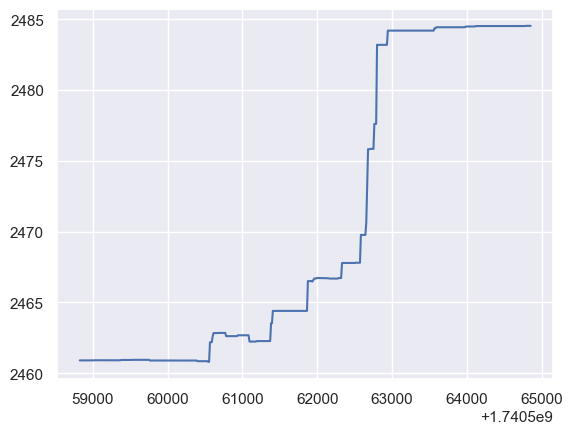

In [40]:
eth_usdc_prices = [p[0] for p in prices]
timestamps = [p[-1] for p in prices]
sns.set()
plt.plot(timestamps, eth_usdc_prices)

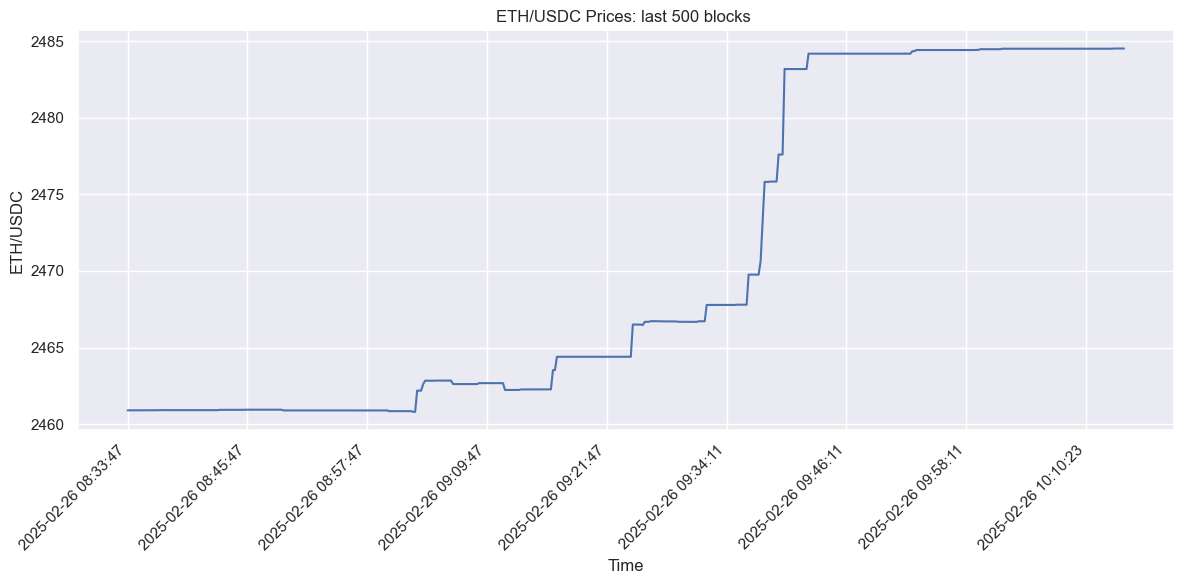

In [41]:
eth_usdc_prices = [p[0] for p in prices]
timestamps = [p[-1] for p in prices]
readable_times = [datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S') for ts in timestamps]

sns.set()
plt.figure(figsize=(12,6))
plt.plot(readable_times, eth_usdc_prices)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Time')
plt.ylabel('ETH/USDC')
plt.title('ETH/USDC Prices: last 500 blocks ')
plt.tight_layout()
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(integer=True, prune='both', nbins=10))
plt.show()

In [42]:
type(prices)

list

In [43]:
df_prices = pd.DataFrame(prices, columns=['eth/usdc','eth/wbtc', 'timestamp'])

In [44]:
df_prices

,eth/usdc,eth/wbtc,timestamp
0,2460.900608,0.027984,1740558827
1,2460.900608,0.027984,1740558839
2,2460.900608,0.027984,1740558851
3,2460.904840,0.027984,1740558863
4,2460.904840,0.027984,1740558875
...,...,...,...
495,2484.521246,0.027933,1740564803
496,2484.521249,0.027933,1740564815
497,2484.521249,0.027933,1740564827
498,2484.521249,0.027933,1740564839


### Using time as dataframe index

In [45]:
df_prices['Date'] = pd.to_datetime(df_prices['timestamp'], unit='s')

In [46]:
df_prices = df_prices.set_index('Date')

In [47]:
df_prices = df_prices.drop('timestamp', axis=1)

In [48]:
df_prices.head()

,eth/usdc,eth/wbtc
Date,,
2025-02-26 08:33:47,2460.900608,0.027984
2025-02-26 08:33:59,2460.900608,0.027984
2025-02-26 08:34:11,2460.900608,0.027984
2025-02-26 08:34:23,2460.904840,0.027984
2025-02-26 08:34:35,2460.904840,0.027984


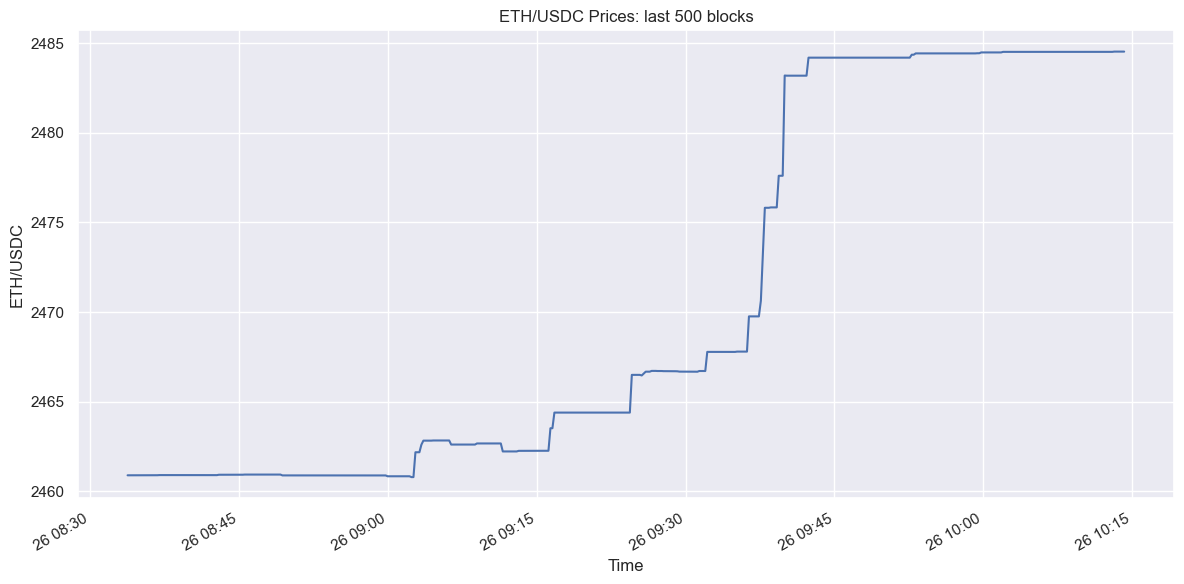

In [49]:
plt.figure(figsize=(12, 6))
df_prices['eth/usdc'].plot()
# or with more customization:
# df_prices['price'].plot(figsize=(12, 6), rot=45)
plt.xlabel('Time')
plt.ylabel('ETH/USDC')
plt.title('ETH/USDC Prices: last 500 blocks')
plt.tight_layout()
plt.show()

In [50]:
df_prices.describe()

,eth/usdc,eth/wbtc
count,500.000000,500.000000
mean,2470.575358,0.027945
std,10.288384,0.000028
min,2460.800206,0.027901
25%,2460.933304,0.027933
50%,2464.396562,0.027933
75%,2484.183923,0.027968
max,2484.521249,0.027984


### Check Volatility 

In [51]:
df_prices['eth/usd_block_change'] = df_prices['eth/usdc'].pct_change() * 100

In [54]:
df_prices.head(10)

,eth/usdc,eth/wbtc,eth/usd_block_change
Date,,,
2025-02-26 08:33:47,2460.900608,0.027984,NaN
2025-02-26 08:33:59,2460.900608,0.027984,0.000000
2025-02-26 08:34:11,2460.900608,0.027984,0.000000
2025-02-26 08:34:23,2460.904840,0.027984,0.000172
2025-02-26 08:34:35,2460.904840,0.027984,0.000000
2025-02-26 08:34:47,2460.904840,0.027984,0.000000
2025-02-26 08:34:59,2460.904840,0.027984,0.000000
2025-02-26 08:35:11,2460.904840,0.027984,0.000000
2025-02-26 08:35:23,2460.904840,0.027984,0.000000


In [55]:
volatility = df_prices['eth/usd_block_change'].std()

In [56]:
print(f"Volatility: {volatility}%")

Volatility: 0.014342196143182166%
